In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import tifffile
from tqdm import tqdm
import gc
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
from tensorflow.keras.applications import *

In [2]:
TRAIN_CSV_DIR = '/kaggle/input/hubmap-organ-segmentation/train.csv'
TEST_CSV_DIR = '/kaggle/input/hubmap-organ-segmentation/test.csv'
TRAIN_IMAGES_DIR = "/kaggle/input/hubmap-organ-segmentation/train_images"
TEST_IMAGES_DIR = "/kaggle/input/hubmap-organ-segmentation/test_images"

In [3]:
train = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/train.csv')
train

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [4]:
def create_file_path(dataframe, image_directory):
    dataframe['file_path'] = dataframe.apply(lambda x: os.path.join(image_directory, str(x.id) + '.tiff'), axis=1)
    return  dataframe

# Training and Validation Data generator

In [5]:
datagen = ImageDataGenerator(
    rotation_range=15,  # Rotation in degrees
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.2,  # Shear angle
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flip
    vertical_flip=False,  # Vertical flip
    fill_mode='reflect'  # Fill mode for new pixels
)


class HubmapOrgan_Dataset(Sequence):
    def __init__(self,dataframe, image_size, batch_size, shuffle=True, augmentation=None):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.indices = np.arange(len(self.dataframe))
        
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
            
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_indices = self.indices[start:end]
        
        with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as executor:
            results = list(executor.map(self.load_image_and_mask, [self.dataframe.iloc[idx]['file_path'] for idx in batch_indices]))
            
        X = []
        y = []
        
        for result in results:
            X.append(result[0])
            y.append(result[1])
            if self.augmentation:
                seed = np.random.randint(100)
                augmented_image = self.augmentation.random_transform(result[0], seed=seed)
                augmented_mask = self.augmentation.random_transform(result[1], seed=seed)
                del seed
                
                X.append(augmented_image)
                y.append(augmented_mask)
        
        return X, y
            
    def load_image_and_mask(self, file_path):
        def normalize_image(image):
            max_val = np.max(image)
            min_val = np.min(image)
            normalized_image = (image - min_val) / (max_val - min_val)
            return normalized_image.astype(float)

        def rle_decode(rle_str, shape):
            s = rle_str.split()
            starts, lengths = [int(x) for x in s[0::2]], [int(x) for x in s[1::2]]
            ends = [start + length for start, length in zip(starts, lengths)]
            mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

            for start, end in zip(starts, ends):
                mask[start:end] = 1

            return mask.reshape(shape, order='F')
        
        def resize_binary_mask(mask, target_shape):
            # Resize the mask using nearest-neighbor interpolation
            resized_mask = cv2.resize(mask, target_shape, interpolation=cv2.INTER_NEAREST)
            
            return np.expand_dims(resized_mask.astype(float), axis=-1)
        
        # Process Image
        image = tifffile.imread(file_path)
        image = cv2.resize(image, self.image_size)
        image = normalize_image(image)
            
        # Process Mask
        rle = self.dataframe[self.dataframe['file_path'] == file_path]['rle'].values[0]
        image_height = self.dataframe[self.dataframe['file_path'] == file_path]['img_height'].values[0]
        image_width = self.dataframe[self.dataframe['file_path'] == file_path]['img_width'].values[0]
        rle = rle_decode(rle, (image_height, image_width))
        segment = resize_binary_mask(rle, self.image_size)
        return image, segment
        

In [6]:
train = create_file_path(train,TRAIN_IMAGES_DIR)
train_df, val_df = train_test_split(train, test_size=0.1, random_state=False)

batch_size = 5
image_size = (1024,1024)

print(f'Number of Samples for Training: {(train_df.shape[0] * 2)}')
print(f'Number of Samples for Validation: {val_df.shape[0]}')
print(f'Number of Sample in one batch: {(batch_size * 2)}')
print(f'Steps per Epochs: {(train_df.shape[0]) / batch_size}')


train_dataset = HubmapOrgan_Dataset(train_df, image_size, batch_size, shuffle=True, augmentation=datagen)
val_dataset = HubmapOrgan_Dataset(val_df, image_size, batch_size, shuffle=False)

train_data_loader = tf.data.Dataset.from_generator(
    lambda: train_dataset,
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *image_size, 1), dtype=tf.float32)
    )
).cache().prefetch(tf.data.AUTOTUNE)

val_data_loader = tf.data.Dataset.from_generator(
    lambda: val_dataset,
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *image_size, 1), dtype=tf.float32)
    )
).cache().prefetch(tf.data.AUTOTUNE)

Number of Samples for Training: 630
Number of Samples for Validation: 36
Number of Sample in one batch: 10
Steps per Epochs: 63.0


## Callbacks

In [7]:
class CustomCallback(Callback):
    def __init__(self, target_accuracy=0.90):
        super(CustomCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_binary_accuracy')
        if val_accuracy is not None and val_accuracy >= self.target_accuracy:
            print(f"\nReached target accuracy ({self.target_accuracy}), stopping training!")
            self.model.stop_training = True

custom_callback = CustomCallback(target_accuracy=0.95)

early_stopper = EarlyStopping(monitor='val_mean_io_u',
                              min_delta= 0.008,
                              patience = 28,
                              restore_best_weights=True,
                              start_from_epoch=12
                             )
#Learning Rate
class LearningRateMetric(tf.keras.metrics.Metric):
    def __init__(self, name='learning_rate', **kwargs):
        super(LearningRateMetric, self).__init__(name=name, **kwargs)
        self.learning_rates = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        current_lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        self.learning_rates.append(current_lr)

    def result(self):
        return self.learning_rates

class CyclicLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=1e-4, max_lr=1e-2, step_size=8, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.clr_iterations = 0
        self.trn_iterations = 0
        self.history = {}

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)

        if self.mode == 'triangular':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x)
        elif self.mode == 'triangular2':
            return self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x) / (2 ** (cycle - 1))

    def on_train_begin(self, logs=None):
        logs = logs or {}
        if self.clr_iterations == 0:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        self.history.setdefault('lr', []).append(tf.keras.backend.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())
        
        
clr = CyclicLR(base_lr=1e-4, max_lr=1e-2, step_size=8, mode='triangular')

## Model

In [8]:
def get_model(img_size, num_classes):
    inputs = Input(shape=(*image_size,3))
    
    ### [First half of the network: downsampling inputs] ###
    
    # Entry block
    x = Conv2D(32, 3, strides=2, padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:
        x = Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64, 32]:
        x = Conv2DTranspose(filters, 3, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)

        x = Conv2DTranspose(filters, 3, padding="same", activation="relu")(x)
        x = BatchNormalization()(x)

        x = UpSampling2D(2)(x)

        # Project residual
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding="same")(residual)
        x = add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = Conv2DTranspose(num_classes, kernel_size=1, activation="sigmoid", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model


#### loss function

In [9]:
def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return 1.0 - (2.0 * intersection + 1.0) / (union + 1.0)

In [10]:
strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])

with strategy.scope():
    
    model = get_model(image_size, 1)
    
    
    model.compile(optimizer='sgd', loss=dice_loss, metrics=['binary_accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]) 

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
n_epochs = 60
callbacks = [custom_callback, early_stopper, clr]

hist = model.fit(train_data_loader, validation_data=val_data_loader, epochs=n_epochs, callbacks=callbacks)

Epoch 1/60
63/63 [==============================] - 338s 5s/step - loss: 0.7300 - binary_accuracy: 0.5909 - mean_io_u: 0.4454 - val_loss: 0.9803 - val_binary_accuracy: 0.9036 - val_mean_io_u: 0.4518
Epoch 2/60
63/63 [==============================] - 100s 2s/step - loss: 0.7008 - binary_accuracy: 0.6472 - mean_io_u: 0.4858 - val_loss: 0.9998 - val_binary_accuracy: 0.9036 - val_mean_io_u: 0.4518
Epoch 3/60
63/63 [==============================] - 99s 2s/step - loss: 0.6586 - binary_accuracy: 0.7624 - mean_io_u: 0.5155 - val_loss: 1.0000 - val_binary_accuracy: 0.9036 - val_mean_io_u: 0.4518
Epoch 4/60
63/63 [==============================] - 94s 1s/step - loss: 0.6224 - binary_accuracy: 0.8127 - mean_io_u: 0.5382 - val_loss: 1.0000 - val_binary_accuracy: 0.9036 - val_mean_io_u: 0.4518
Epoch 5/60
63/63 [==============================] - 100s 2s/step - loss: 0.6082 - binary_accuracy: 0.8263 - mean_io_u: 0.5508 - val_loss: 1.0000 - val_binary_accuracy: 0.8967 - val_mean_io_u: 0.4494
Epoch 6

In [13]:
model.save('binary_segmentation.h5')

### Plot Model Predictions

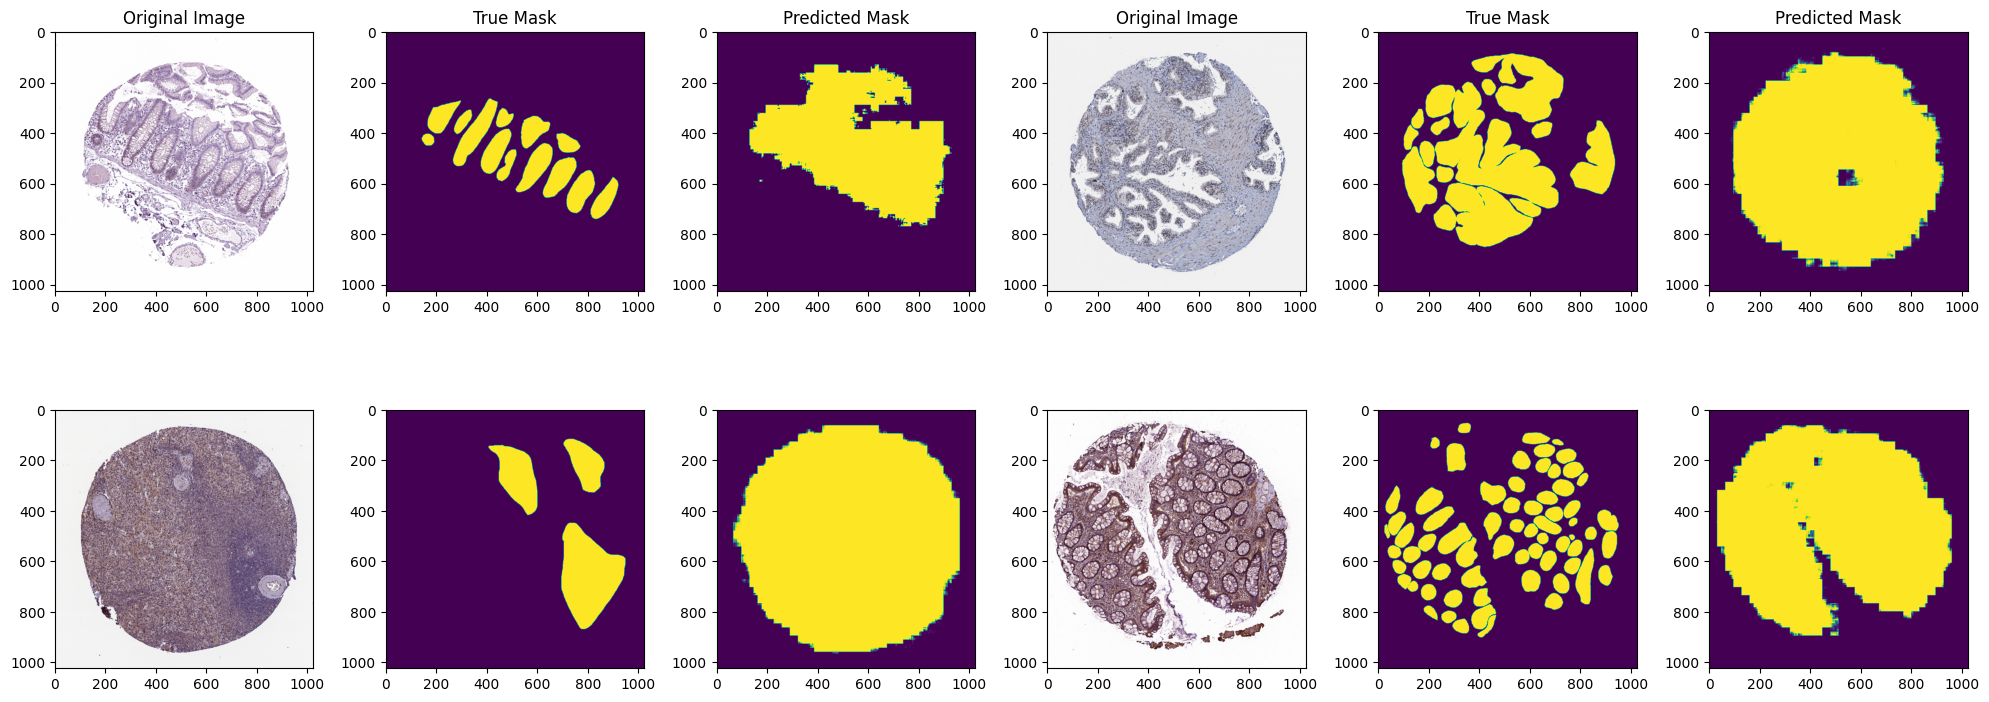

In [14]:
val_image, val_mask = next(iter(val_data_loader))
pred = model.predict(val_image, verbose=False)

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20,8))
axes[0,0].imshow(val_image[0])
axes[0,0].set_title('Original Image')
axes[0,1].imshow(val_mask[0])
axes[0,1].set_title('True Mask')
axes[0,2].imshow((pred[0] > 0.5))
axes[0,2].set_title('Predicted Mask')

axes[0,3].imshow(val_image[1])
axes[0,3].set_title('Original Image')
axes[0,4].imshow(val_mask[1])
axes[0,4].set_title('True Mask')
axes[0,5].imshow(pred[1])
axes[0,5].set_title('Predicted Mask')

axes[1,0].imshow(val_image[2])
axes[1,1].imshow(val_mask[2])
axes[1,2].imshow(pred[2])

axes[1,3].imshow(val_image[3])
axes[1,4].imshow(val_mask[3])
axes[1,5].imshow(pred[3])

plt.tight_layout()
plt.savefig('performance.png')
plt.show()

## Model Performance Chart

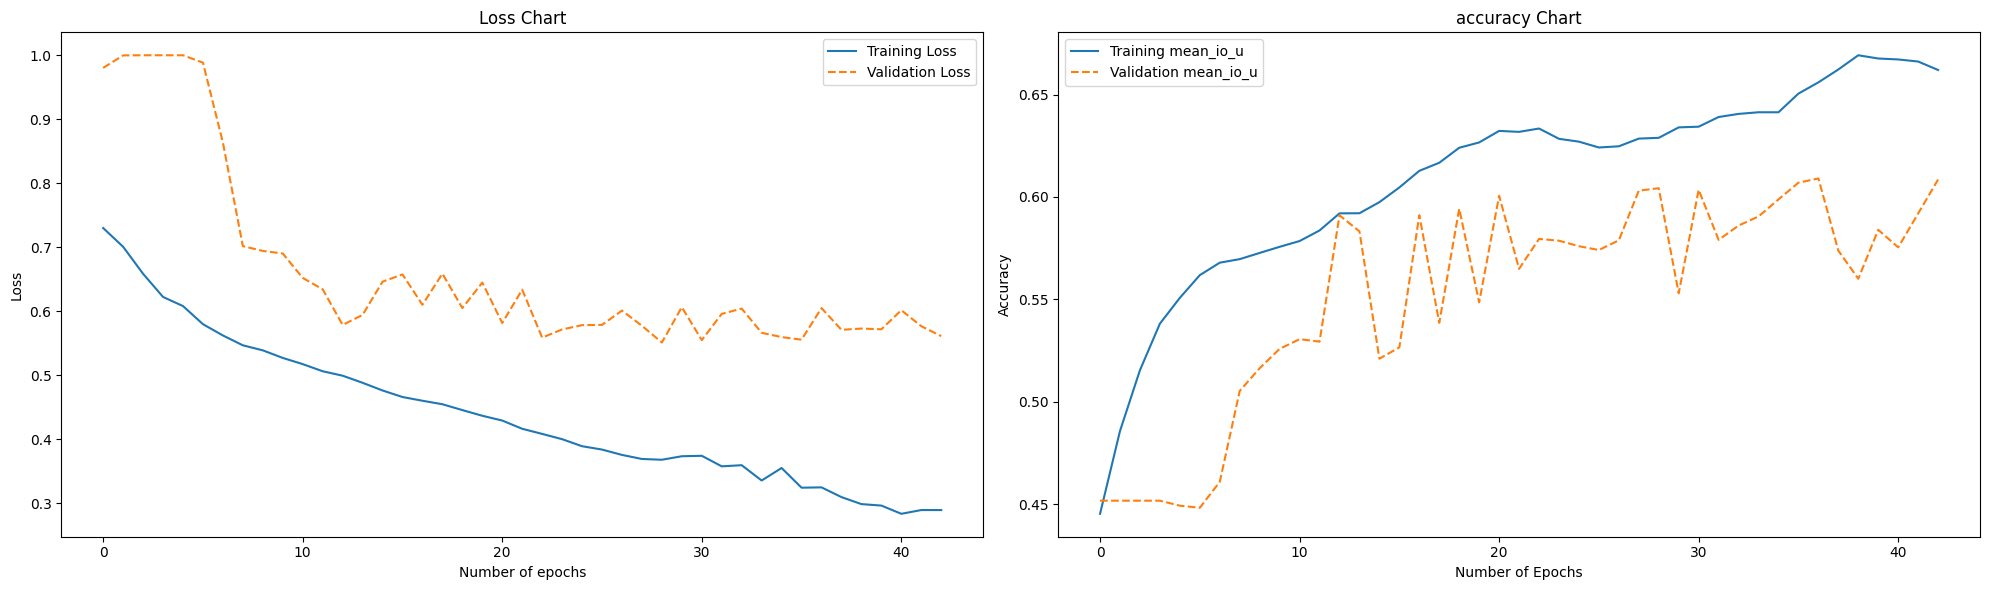

In [15]:
fig,axes = plt.subplots(ncols=2,figsize=(20,6))
sns.lineplot(hist.history['loss'], ax=axes[0], label='Training Loss')
sns.lineplot(hist.history['val_loss'], ax=axes[0], linestyle='--', label='Validation Loss')
axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Chart')

sns.lineplot(hist.history['mean_io_u'], ax=axes[1], label='Training mean_io_u')
sns.lineplot(hist.history['val_mean_io_u'], ax=axes[1], linestyle='--', label='Validation mean_io_u')
axes[1].set_xlabel('Number of Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('accuracy Chart')

plt.tight_layout()
plt.savefig('segmentation_model.png')
plt.show()

# Submission

In [16]:
def rle_encode(img):
    """ TBD
    
    Args:
        img (np.array): 
            - 1 indicating mask
            - 0 indicating background
    
    Returns: 
        run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [17]:
test = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/test.csv')
test['rle'] = '1'

test = create_file_path(test, TEST_IMAGES_DIR)

test_dataset = HubmapOrgan_Dataset(test, image_size, batch_size, shuffle=False)
test_data_loader = tf.data.Dataset.from_generator(
    lambda : test_dataset, 
    output_signature=(
        tf.TensorSpec(shape=(None, *image_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *image_size, 1), dtype=tf.float32)
    )
).cache().prefetch(tf.data.AUTOTUNE)

In [18]:
pred_masks = []

for batch in test_data_loader:
    batch_images = batch[0]
    batch_pred = model.predict(batch_images, verbose=False)
    
    for i in range(batch_pred.shape[0]):
        prob_mask = batch_pred[i]
        pred_mask = (prob_mask > 0.5).astype(np.uint8)
        rle_mask = rle_encode(pred_mask)
        pred_masks.append(rle_mask)
        
submission = pd.DataFrame({'id': test['id'], 'rle' : pred_masks})
submission.to_csv('submission.csv', index=False)